
# List 1

Krzysztof Jankowski


## Imports


In [8]:
import numpy as np
from pydantic import validate_call, PositiveInt
from enum import Enum, auto
import matplotlib.pyplot as plt

In [2]:
class State(Enum):
    positive = auto()
    negative = auto()

c0 <- initial concentration

c+ <- positive opinion

c- <- negative opinion

$$
c^+=\frac{1}{N}\sum^N_{i-1}\frac{(S_i+1)}{2}\in\bigl[0,1\bigr]
$$

$$
c^-=1-c^+
$$
$$
Pr(S_i(t=0)=1)=c_0
$$

In [91]:
class SznajdModel:
    @validate_call
    def __init__(self, n: int, t: int, c0: float) -> None:
        self.n = n
        self.t = t
        self.c0 = c0
    
    def run(self):
        self._pre_init_simulation()
        for i in range(self.t):
            self._update(i)
        
    def _pre_init_simulation(self) -> None:
        #Optimization stuff
        self.graph = self._init_graph()
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))
    
    def _init_graph(self) -> np.ndarray[State]:
        init = np.random.choice(list(State), size=self.n, p=[self.c0, 1 - self.c0])
        graph_evolution = np.ndarray((self.t+1, self.n), dtype=State)
        graph_evolution[0,:] = init
        return graph_evolution
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        an initial state. Therefore i-th update row corresponds with i-th + 1
        graph evolution row. 
        """
        self.graph[step+1,:] = self.graph[step,:]
        for substep in self.choice[step]:
            if self.graph[step+1][substep] == self.graph[step+1][(substep + 1) % self.n]:
                self._agreement_update(step+1, substep)
            else:
                self._disagreement_update(step+1, substep)
            
    
    def _agreement_update(self, step: int, pos: int) -> None:
        state = self.graph[step][pos]
        self.graph[step, (pos - 1) % self.n] = state
        self.graph[step, (pos + 2) % self.n] = state
    
    def _disagreement_update(self, step: int, pos: int) -> None:
        self.graph[step][(pos - 1) % self.n] = self.graph[step][(pos + 1) % self.n]
        self.graph[step][(pos + 2) % self.n] = self.graph[step][pos]
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)
    

In [92]:
def task_1() -> None:
    n = 100
    t = 100
    c_inits = [0.25, 0.5, 0.75]
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for idx, c in enumerate(c_inits):
        model = SznajdModel(n, t, c)
        model.run()
        
        current_ax = axes.flatten()[idx]
        current_ax.imshow(model.get_graph_evolution(), cmap='viridis', interpolation='nearest')
        current_ax.set_title(f"$c_0={c}$")
        current_ax.set_xlabel("State")
    axes.flatten()[0].set_ylabel("T")
    fig.suptitle("Sznajd Model USDF evolution")
    fig.tight_layout()
        

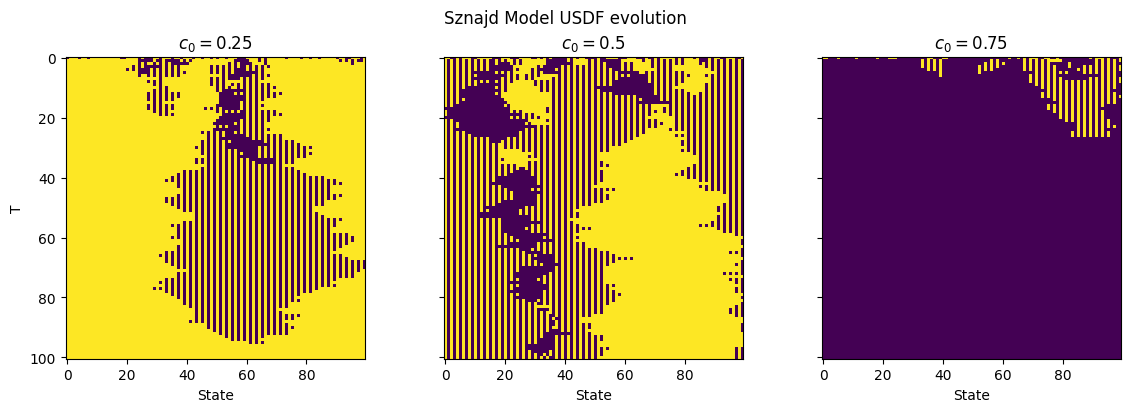

In [94]:
task_1()

In [ ]:
class SznajdModel:
    @validate_call
    def __init__(self, n: int, t: int, c0: float) -> None:
        self.n = n
        self.t = t
        self.c0 = c0
    
    def run(self):
        self._pre_init_simulation()
        for i in range(self.t):
            self._update(i)
        
    def _pre_init_simulation(self) -> None:
        #Optimization stuff
        self.graph = self._init_graph()
        self.choice = np.random.randint(low=0, high=self.n-1, size=(self.t, self.n))
    
    def _init_graph(self) -> np.ndarray[State]:
        init = np.random.choice(list(State), size=self.n, p=[self.c0, 1 - self.c0])
        graph_evolution = np.ndarray((self.t+1, self.n), dtype=State)
        graph_evolution[0,:] = init
        return graph_evolution
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        In that case, at first, we copy state (row) from the previous update or 
        init state, to the current updated row. Have in mind that first row is 
        an initial state. Therefore i-th update row corresponds with i-th + 1
        graph evolution row. 
        """
        self.graph[step+1,:] = self.graph[step,:]
        for substep in self.choice[step]:
            if self.graph[step+1][substep] == self.graph[step+1][(substep + 1) % self.n]:
                self._agreement_update(step+1, substep)
            else:
                self._disagreement_update(step+1, substep)
            
    
    def _agreement_update(self, step: int, pos: int) -> None:
        state = self.graph[step][pos]
        self.graph[step, (pos - 1) % self.n] = state
        self.graph[step, (pos + 2) % self.n] = state
    
    def _disagreement_update(self, step: int, pos: int) -> None:
        self.graph[step][(pos - 1) % self.n] = self.graph[step][(pos + 1) % self.n]
        self.graph[step][(pos + 2) % self.n] = self.graph[step][pos]
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)
    